In [ ]:
#from google.colab import drive
#import os
#drive.mount('/content/drive')
#!cp "/content/drive/MyDrive/ML/Dataset.zip" /content/

In [ ]:
!wget https://filesender.unina.it/filesender/download.php?vid=64e83eb7-e645-4608-1267-00005fed5f3d -O /content/Dataset.zip

--2022-12-15 19:00:19--  https://filesender.unina.it/filesender/download.php?vid=64e83eb7-e645-4608-1267-00005fed5f3d
Resolving filesender.unina.it (filesender.unina.it)... 192.132.34.18, 2001:760:3403:ffff::12
Connecting to filesender.unina.it (filesender.unina.it)|192.132.34.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210806307 (201M) [application/octet-stream]
Saving to: ‘/content/Dataset.zip’

/content/Dataset.zi 100%[===================>] 201.04M  5.14MB/s    in 43s     

2022-12-15 19:01:04 (4.70 MB/s) - ‘/content/Dataset.zip’ saved [210806307/210806307]



In [ ]:
!rm -r -f /content/Dataset

!unzip -q /content/Dataset.zip -d /content/Dataset/ 
%cd /content/Dataset
!ls

/content/Dataset
efficientNet  mobileNet  resNet34


In [ ]:
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import random
from random import shuffle
import matplotlib.pyplot as plt

# KFold
from sklearn.model_selection import KFold

In [ ]:
# ALL PARAMETERS
NUMBER_OF_CLASSES = 4
BATCH_SIZE = 32
LEARNING_RATE = 0.00035
DECAY = 0.0008
#DECAY = 0.001
EPOCHS = 300

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
if(torch.cuda.is_available()):
  print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.13.0+cu116
True
Tesla T4
cuda:0


In [ ]:
# POV: you want to make the execution deterministic
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Loading and Preparation

In [ ]:
class MyDataset():
 
  def __init__(self, *args):
    if(len(args) == 1 and isinstance(args[0], str)):
      df_data=pd.read_csv(args[0])
      df_data.set_index(["images", "cone_name"], inplace=True)
  
      self.x=df_data.iloc[:,:-1]
      self.y=df_data.iloc[:,-1]
      
      self.y -= 1
    elif(len(args) == 2):
      self.x = args[0]
      self.y = args[1]
    else:
      raise ValueError("Too many arguments")
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self, idx):
    return self.x[idx],self.y[idx]

  def split(self, frac, replace_dataset=True, sampling_type = "stratified", *args, **kwargs):
    '''
      2-way split of the dataset.
      The split is frac : (1-frac)

      If replace_dataset=True the left split is not returned and stored into the current instance
    '''
    assert isinstance(self.x, pd.DataFrame), "[ERROR] Can't split Dataset if prepare() has been called"
    assert sampling_type in ["stratified", "random"], f"[ERROR] sampling_type '{sampling_type}' not supported"
    if(sampling_type == "random"):
      x_left = self.x.sample(frac = frac, *args, **kwargs)
      y_left = self.y[x_left.index]
    elif(sampling_type == "stratified"):
      filter = pd.DataFrame(self.y).groupby('label', group_keys=False).apply(
                  lambda x: x.sample(frac = frac, *args, **kwargs)
              )

      indexes = [np.where(index == self.x.index)[0][0] for index in filter.index]

      x_left = self.x.iloc[indexes, :]
      y_left = self.y[x_left.index]

    x_right = self.x.drop(x_left.index)
    y_right = self.y.drop(x_left.index)

    if(replace_dataset == True):
      self.x = x_left
      self.y = y_left
      return MyDataset(x_right, y_right)
    else:
      return MyDataset(x_left, y_left), MyDataset(x_right, y_right)


  def normalize(self, type):
    if(type == "zscore"):
      means = self.x.mean(axis=0)
      stds = self.x.std(axis=0, ddof=1)

      self.x = (self.x - means)/stds
      return means, stds
    else:
      raise NotImplementedError()
  
  def normalizer_apply(self, type, *args):
    if(type == "zscore"):
      means = args[0]
      stds = args[1]

      self.x = (self.x - means)/stds
    else:
      raise NotImplementedError()

  def KFoldCrossvalidation(self, folds, shuffle = True, random_state = None):
    splits = KFold(n_splits = folds,shuffle = shuffle,random_state = random_state)
    return splits.split(np.arange(len(self.y)))

  
  def prepare(self):
    '''
      Prepare the dataset (i.e. convert the DataFrame(s) into torch.tensor(s))
    '''
    self.x = torch.tensor(self.x.values, dtype=torch.float32)
    self.y = torch.tensor(self.y.values, dtype=torch.float32)

In [ ]:
datasetNetwokName = r"resNet34"
assert datasetNetwokName in [r"mobileNet", r"efficientNet", r"resNet34"], "Network data not provided"

data = MyDataset(r"/content/Dataset/" + datasetNetwokName + "/train.csv")

original_shape = data.x.shape
print(f"Dataset loaded, the shape is: {data.x.shape}")


data_test = data.split(frac = .8, replace_dataset = True, sampling_type = "stratified", replace = False, random_state = 1846)
data_train, data_valid = data.split(frac = .75, replace_dataset = False, sampling_type = "stratified", replace = False, random_state = 1846)

m,s = data_train.normalize("zscore")
data_valid.normalizer_apply("zscore", m , s)
data_test.normalizer_apply("zscore", m , s)

print(f"Data splitted:")
print(f"\tTrain: {data_train.x.shape[0]/original_shape[0]}\n\tValid: {data_valid.x.shape[0]/original_shape[0]}\n\tTest: {data_test.x.shape[0]/original_shape[0]}")

Dataset loaded, the shape is: (11170, 512)
Data splitted:
	Train: 0.6
	Valid: 0.2
	Test: 0.2


In [ ]:
data_train.prepare()
data_valid.prepare()
data_test.prepare()

dataloaders = {
    'TRAIN': torch.utils.data.DataLoader(data_train, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2),
    'val': torch.utils.data.DataLoader(data_valid, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2),
    #'test': torch.utils.data.DataLoader(data_test, batch_size = BATCH_SIZE, num_workers = 2)
}

## Model definition

In [ ]:
#find best model on validation test
def train_loop_validation(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv,
                          best_acc, best_loss, best_epoca, outputPath):
  
  if(startEpoch == 1):    # If we are not resuming training
    try:
      import shutil
      shutil.rmtree(outputPath)
    except:
      pass
    finally:
      os.mkdir(outputPath)

  for epochs in range(startEpoch, numEpochs + 1):
    since = time.time()
    
    modelLoss_train = 0.0
    modelAcc_train = 0.0

    model_conv.train() 

    totalSize = 0

    alltime_loss_train = []
    alltime_loss_valid = []

    alltime_acc_train = []
    alltime_acc_valid = []
    
    
    #for each batch
    for inputs, labels in dataloaders['TRAIN']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.type(torch.LongTensor).cuda()
      
      optimizer_conv.zero_grad()
      model_conv.zero_grad()
      
      # 2) compute the prediction
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
      # preds = torch.argmax(y, 1) is definetely more readable

      lossCNN = criterionCNN(y, labels) #media per batch 
      # For each batch we compute the mean of the loss function


      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      # 3) compute the gradient
      lossCNN.backward()  # pred = f(x)   -> loss = L(f(x), l_true)
      optimizer_conv.step() # update weights    
    
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    #salvataggio dei pesi ad ogni iterazione -> nel caso si blocchi e vogliamo riprendere il train 
    torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth')
    
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    # Compute the validation set -> Once for each epoch
    for inputs, labels in dataloaders['val']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.type(torch.LongTensor).cuda()
      
      y = model_conv(inputs) #16x29
      outp, preds = torch.max(y, 1) 
      lossCNN = criterionCNN(y, labels)


      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()
    
      
    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    #print(time_elapsed)
    print('[Epoch %d] [TRAIN [Loss: %.4f  ACC: %.4f]] [VAL [Loss: %.4f  ACC: %.4f]] [TIME: %.0f m %.0f s]' 
          %(epochs, modelLoss_epoch_train, modelAcc_epoch_train, modelLoss_epoch_val, 
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))
    
    #if epochs == 1 or modelLoss_epoch_val < best_loss:
    if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
      print('     .... Saving best weights ....')
      best_acc = modelAcc_epoch_val
      best_loss = modelLoss_epoch_val
      best_epoca = epochs
      #salvataggio dei migliori pesi sul validation
      torch.save(model_conv.state_dict(), outputPath + 'best_model_weights.pth')
      
    with open(outputPath + 'lossTrain.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_train) +'\n')
      
    with open(outputPath + 'AccTrain.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_train)+'\n')
      
    with open(outputPath + 'lossVal.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_val)+'\n')
      
    with open(outputPath + 'AccVal.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_val)+'\n')
      
    sio.savemat(outputPath + 'check_point.mat', {'best_acc': best_acc, 
                                                 'best_loss': best_loss,
                                                 'best_epoca': best_epoca,
                                                 'last_epoch': epochs})

    # Plot
    '''
    alltime_loss_train.append(modelLoss_epoch_train)
    alltime_loss_valid.append(modelLoss_epoch_val)

    alltime_acc_train.append(modelAcc_epoch_train)
    alltime_acc_valid.append(modelAcc_epoch_val)

    if(epochs%10 == 1):
      if(epochs == 1):
        fig = plt.figure()
        plt.title("Training Vs Validation Accuracies")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
      else:
        plt.plot(list(range(1, len(alltime_loss_train)+1)), alltime_loss_train, color='r', label="Training Accuracy")
        plt.plot(list(range(1, len(alltime_loss_valid)+1)), alltime_loss_valid, color='r', label="Training Accuracy")

        plt.show()
    '''


In [ ]:
networkName = "custom5"

weightPath = r"/content/" + networkName + "/"
try:
  os.makedirs(weightPath)
except:
  pass

if(networkName == "mobileNet"):
  model_conv = torchvision.models.mobilenet_v2(pretrained=True)#weights = "IMAGENET1K_V1")
  model = model_conv.classifier
  model[-1] = nn.Linear(model[-1].in_features, NUMBER_OF_CLASSES)

elif (networkName == "resNet34"):
  model_conv = torchvision.models.resnet34(pretrained=True)
  model = model_conv.fc
  model = nn.Linear(model.in_features, NUMBER_OF_CLASSES)

elif (networkName == "efficientNet"):
  model_conv = torchvision.models.efficientnet_b0(pretrained=True)
  model = model_conv.classifier
  model[-1] = nn.Linear(model[-1].in_features, NUMBER_OF_CLASSES)

elif (networkName == "custom1"):
  model = nn.Sequential(
      nn.Linear(original_shape[1], 500),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(500, 100),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(100, NUMBER_OF_CLASSES)
  )
elif (networkName == "custom2"):
  model = nn.Sequential(
      nn.Dropout(0.35),
      nn.Linear(original_shape[1], 500),
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Linear(500, 100),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(100, NUMBER_OF_CLASSES)
  )
elif (networkName == "custom3"):
  model = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(original_shape[1], 500),
      nn.ReLU(),
      nn.Dropout(0.45),
      nn.Linear(500, 100),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(100, NUMBER_OF_CLASSES)
  )
elif (networkName == "custom4"):    # To commit
  model = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(original_shape[1], 500),
      nn.ReLU(),
      nn.Dropout(0.45),
      nn.Linear(500, 128),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(128, NUMBER_OF_CLASSES)
  )
elif (networkName == "custom5"):
  model = nn.Sequential(
      nn.Dropout(0.55),
      nn.Linear(original_shape[1], 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.35),
      nn.Linear(256, 128),
      nn.Dropout(0.3),
      nn.ReLU(),
      nn.Linear(128,NUMBER_OF_CLASSES)
  )
else:
  raise NotImplementedError()

print(model)

# Resize the output

'''
try:
  ftrs = model[0].in_features
except:
  ftrs = model[1].in_features

assert ftrs  == original_shape[1], "Input shape of model does not match feature size"
'''
#model_conv[1] = nn.Linear(original_shape[1], model_conv[1].out_features)
#print(model_conv)


for param in model.parameters():
  param.requires_grad = True

model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = DECAY)

Sequential(
  (0): Dropout(p=0.55, inplace=False)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.35, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=4, bias=True)
)


## Training

In [ ]:
do_kfold = False
# ^^^ Se lo metti True ti si spegne il pc

startEpoch = 1
best_acc   = 0
best_loss  = 0
best_epoch = 0

if(do_kfold):
  # split the dataset based on folds
  data_kfold = MyDataset(r"/content/Dataset/" + datasetNetwokName + "/train.csv")

  splits = data_kfold.KFoldCrossvalidation(folds = 10, shuffle = True, random_state = 1846)

  data_kfold.prepare()
  
  from copy import deepcopy
  model_backup = deepcopy(model)

  for fold_number, (train_index, valid_index) in enumerate(splits):
    model = deepcopy(model_backup)
    print(f"[ FOLD {fold_number} ]")
    kfold_weightPath = weightPath[:-1] + f"_fold{fold_number}/"

    data_train, data_valid = data_kfold[train_index], data_kfold[valid_index]
    data_train, data_valid = MyDataset(data_train[0], data_train[1]), MyDataset(data_valid[0], data_valid[1])
    assert len(data_train.y) + len(data_valid.y) == len(data_kfold.y)

    m,s = data_train.x.mean(dim=0), data_train.x.std(dim=0, unbiased=True)
    data_train.x = (data_train.x-m)/s
    data_valid.x = (data_valid.x-m)/s

    kfold_dataloaders = {
      'TRAIN': torch.utils.data.DataLoader(data_train, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2),
      'val': torch.utils.data.DataLoader(data_valid, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
    }
    train_loop_validation(kfold_dataloaders, startEpoch, 50, model, criterion, optimizer_conv, best_acc, best_loss, best_epoch, kfold_weightPath)
else:
  train_loop_validation(dataloaders, startEpoch, EPOCHS, model, criterion, optimizer_conv, best_acc, best_loss, best_epoch, weightPath)

[Epoch 1] [TRAIN [Loss: 0.8536  ACC: 0.6465]] [VAL [Loss: 0.3753  ACC: 0.8845]] [TIME: 0 m 4 s]
     .... Saving best weights ....
[Epoch 2] [TRAIN [Loss: 0.4915  ACC: 0.8068]] [VAL [Loss: 0.2808  ACC: 0.9150]] [TIME: 0 m 1 s]
     .... Saving best weights ....
[Epoch 3] [TRAIN [Loss: 0.4383  ACC: 0.8365]] [VAL [Loss: 0.2567  ACC: 0.9194]] [TIME: 0 m 1 s]
     .... Saving best weights ....
[Epoch 4] [TRAIN [Loss: 0.3853  ACC: 0.8535]] [VAL [Loss: 0.2268  ACC: 0.9293]] [TIME: 0 m 1 s]
     .... Saving best weights ....
[Epoch 5] [TRAIN [Loss: 0.3595  ACC: 0.8678]] [VAL [Loss: 0.2073  ACC: 0.9329]] [TIME: 0 m 1 s]
     .... Saving best weights ....
[Epoch 6] [TRAIN [Loss: 0.3428  ACC: 0.8772]] [VAL [Loss: 0.2065  ACC: 0.9369]] [TIME: 0 m 1 s]
     .... Saving best weights ....
[Epoch 7] [TRAIN [Loss: 0.3538  ACC: 0.8723]] [VAL [Loss: 0.2062  ACC: 0.9378]] [TIME: 0 m 1 s]
     .... Saving best weights ....
[Epoch 8] [TRAIN [Loss: 0.3458  ACC: 0.8744]] [VAL [Loss: 0.1958  ACC: 0.9387]] [TI

## Performance

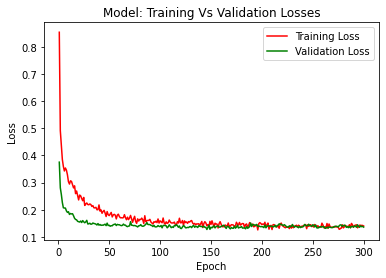

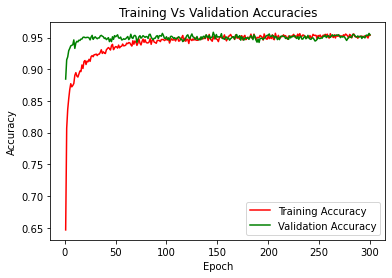

In [ ]:
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

file = open(weightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open(weightPath + 'lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(weightPath + 'LossTrainVal.png')

file = open(weightPath + 'AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open(weightPath + 'AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(weightPath + 'AccTrainVal.png')

In [ ]:
import copy

best_model = copy.deepcopy(model)
best_model.load_state_dict(torch.load("/content/" + networkName + '/best_model_weights.pth'))

best_model

Sequential(
  (0): Dropout(p=0.55, inplace=False)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.35, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
# Disable dropout
best_model.eval()

x = data_test.x.type(torch.FloatTensor).cuda()
y = data_test.y.type(torch.LongTensor).cuda()
y_pred = best_model(x)

y_pred = y_pred.argmax(dim=1).cpu().numpy()
y = y.cpu().numpy()

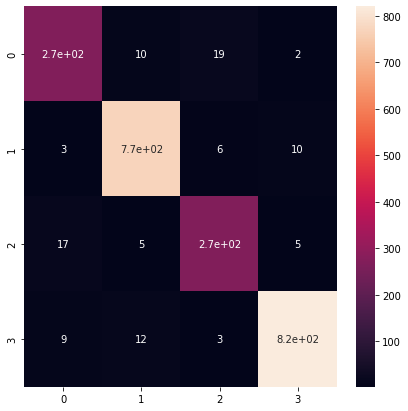

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

c = confusion_matrix(y,y_pred, labels=list(range(0,4)))
df_cm = pd.DataFrame(c , index = [i for i in list(range(0,4))],
                  columns = [i for i in list(range(0,4))])
plt.figure(figsize = (7,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
accuracy = np.sum(y == y_pred)/len(y)

print(f"{accuracy = :.2%}")

y_pred

accuracy = 95.48%


array([1, 1, 0, ..., 0, 2, 0])

## kaggle test prediction

In [ ]:
kaggle_test = pd.read_csv("/content/Dataset/" + datasetNetwokName + "/test.csv")

kaggle_test.set_index("image", inplace=True)

kaggle_test = (kaggle_test - m)/s

x = torch.tensor(kaggle_test.values, dtype=torch.float32).cuda()
kaggle_pred = best_model(x).argmax(dim=1).cpu().numpy()

kaggle_pred = kaggle_pred + 1
print(kaggle_pred)

[4 4 2 ... 1 2 1]


In [ ]:
kaggle_commit = pd.concat([pd.Series(kaggle_test.index), pd.Series(kaggle_pred)], axis=1, ignore_index=True)
kaggle_commit.columns = ["ID", "class"]
kaggle_commit.to_csv("/content/commit.csv", index=False)

kaggle_commit

,ID,class
0,img_1,4
1,img_2,4
2,img_3,2
3,img_4,1
4,img_5,3
...,...,...
6342,img_6343,3
6343,img_6344,1
6344,img_6345,1
6345,img_6346,2
